<a href="https://colab.research.google.com/github/seoyeon7/ML_IDS_Project/blob/main/LSTM_AE_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES']=''

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn import metrics

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random as rn
from numpy.random import seed

from scipy.io.arff import loadarff
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 데이터 불러오기

In [ ]:
noraml_data_raw = pd.read_csv("/content/normal.csv")
abnoraml_data_raw = pd.read_csv("/content/abnormal.csv")

In [ ]:
# 데이터 리스트화
normal_data_list = noraml_data_raw['ID'].values.tolist()
abnormal_data_list = abnoraml_data_raw['ID'].values.tolist()

In [ ]:
# 데스트 데이터, 검정 데이터 분리

normal_data = np.array(normal_data_list).reshape(10485,100)
normal_data_train = normal_data[:8000]
normal_data_test = normal_data[8000:]

abnormal_data = np.array(normal_data_list).reshape(10485,100)
abnormal_data_test = abnormal_data[:2485]

from sklearn.model_selection import train_test_split

normal_test_tot=np.hstack((normal_data_test, np.zeros(normal_data_test.shape[0]).reshape(-1,1)))
abnormal_test_tot=np.hstack((abnormal_data_test, np.ones(abnormal_data_test.shape[0]).reshape(-1,1)))
test_tot = np.vstack((normal_test_tot, abnormal_test_tot))

x_test, x_vaild, y_test, y_vaild = train_test_split(test_tot[:,:-1], test_tot[:,-1], test_size=0.3)

In [ ]:
print(x_test.shape)
print(x_vaild.shape)
print(y_test.shape)
print(y_vaild.shape)

(3479, 100)
(1491, 100)
(3479,)
(1491,)


In [ ]:
# z-score 정규화

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

stder = StandardScaler()
stder.fit(normal_data_train)
x_normal_train_scaled = stder.transform(normal_data_train)
x_test_scaled = stder.transform(x_test)
x_valid_scaled = stder.transform(x_vaild)

In [ ]:
# LSTM 입력 데이터 형태로 변경

x_normal_train_scaled = x_normal_train_scaled.reshape(x_normal_train_scaled.shape[0], 1, x_normal_train_scaled.shape[1])
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1])
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1])

print("훈련 정상 데이터 : ", x_normal_train_scaled.shape)
print("검증 데이터  : ", x_valid_scaled.shape)
print("테스트 데이터 : ", x_test_scaled.shape)

훈련 정상 데이터 :  (8000, 1, 100)
검증 데이터  :  (1491, 1, 100)
테스트 데이터 :  (3479, 1, 100)


# LSTM AE 모델 생성

In [ ]:
# 오토인코더 신경망 구축

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras import regularizers
from keras.models import Model

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# 모델 생성

model = autoencoder_model(x_normal_train_scaled)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1, 100)]          0         
                                                                 
 lstm_52 (LSTM)              (None, 1, 32)             17024     
                                                                 
 lstm_53 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_14 (RepeatVec  (None, 1, 16)            0         
 tor)                                                            
                                                                 
 lstm_54 (LSTM)              (None, 1, 16)             2112      
                                                                 
 lstm_55 (LSTM)              (None, 1, 32)             6272      
                                                          

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
# 모델 학습 및 평가

nb_epochs = 100
batch_size = 64
callbacks = [EarlyStopping(monitor='val_loss', patience=50)]
history = model.fit(x_normal_train_scaled, x_normal_train_scaled, epochs=nb_epochs, batch_size=batch_size, callbacks=callbacks, validation_split=0.3).history

Epoch 1/100
88/88 [==============================] - 7s 17ms/step - loss: 0.0986 - val_loss: 0.0837
Epoch 2/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0834 - val_loss: 0.0836
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0834 - val_loss: 0.0836
Epoch 4/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0834 - val_loss: 0.0836
Epoch 5/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0834 - val_loss: 0.0836
Epoch 6/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0834 - val_loss: 0.0836
Epoch 7/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0834 - val_loss: 0.0836
Epoch 8/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0834 - val_loss: 0.0836
Epoch 9/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0834 - val_loss: 0.0836
Epoch 10/100
88/88 [==============================] - 1s 8ms/step - loss: 0.0834 - val_loss: 0.0836
Epoch 11

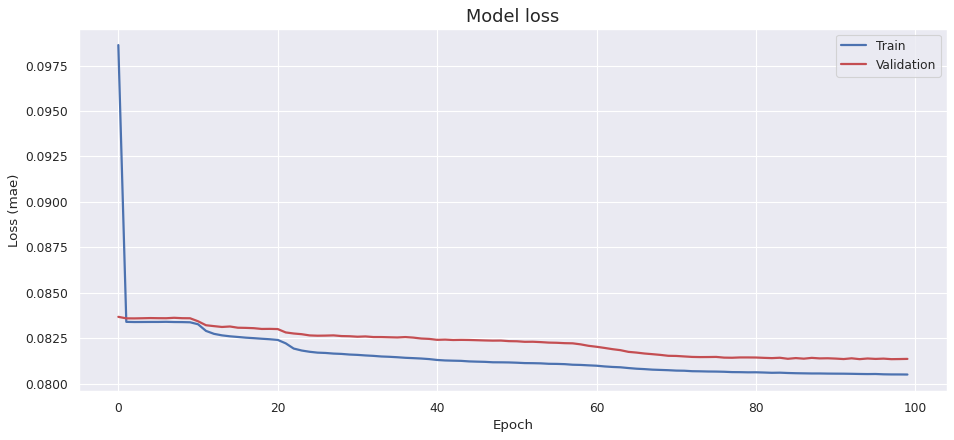

In [ ]:
#학습 손실 시각화

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


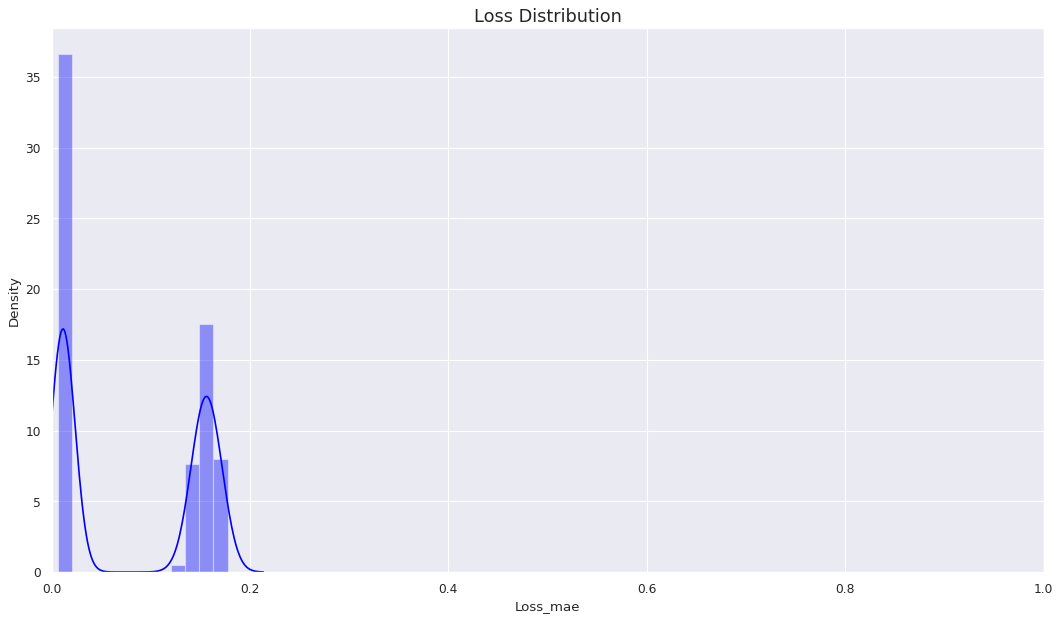

In [ ]:
import seaborn as sns
sns.set(color_codes=True)

X_pred = model.predict(x_normal_train_scaled)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) 
X_pred = pd.DataFrame(X_pred)
 
Xtrain = x_normal_train_scaled.reshape(x_normal_train_scaled.shape[0], x_normal_train_scaled.shape[2]) 
scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1) 

Threshold = 0.17

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
plt.xlim([0,1])
sns.distplot(scored['Loss_mae'], kde= True, color = 'blue');

precision: 0.5552731893265566
recall: 0.5552731893265566
threshold: 0.00026299774085678716


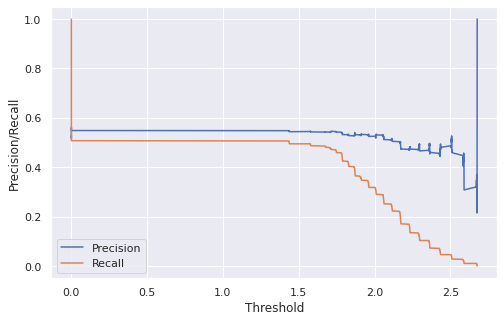

In [ ]:
X_pred_3d = model.predict(x_valid_scaled)
X_pred = X_pred_3d.reshape(X_pred_3d.shape[0], X_pred_3d.shape[2])
X_valid_ = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[2])

mse = np.mean(np.power(X_valid_ - X_pred, 2), axis=1) 
error_df = pd.DataFrame({'Reconstruction_error' : mse, 
                         'True_class': y_vaild})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt-recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]

print('precision:', precision_rt[np.argmin(best_cnt_dic)])
print('recall:', recall_rt[np.argmin(best_cnt_dic)])
print('threshold:', threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# 모델 성능 평가

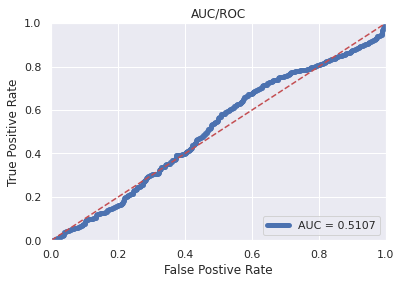

In [ ]:
# AUC/ROC 지표

fpr, tpr, Thresholds = roc_curve(y_vaild, mse)
roc_auc = auc(fpr, tpr)

plt.title('AUC/ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc, linewidth=5 )
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0,1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Postive Rate')
plt.show();
